### Download
In case this link is broken, this zipped folder contains csv files with
metadata from articles written by UFRN-related authors that fits with a specific
SDG goal. There were 4 .csv files, for 2023 SDG goals 3, 7, 15 and 17, gathered with Elsevier's Scopus tool during mid July 2024.

In [ ]:
!curl -L -o ODSes.zip https://www.dropbox.com/scl/fo/jzl5zaq3m44b7rzs6j974/AL7_0Uc_Rb99O46NG3SRDNc?rlkey=9yo3c5r7wtlxeg9iqpdag09sb&st=94jlq42r&dl=1
!unzip ODSes.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17  100    17    0     0     18      0 --:--:-- --:--:-- --:--:--    18
100 55.2M  100 55.2M    0     0  22.4M      0  0:00:02  0:00:02 --:--:-- 43.1M
Archive:  ODSes.zip
mapname:  conversion of  failed
 extracting: scopusODS7.csv          
 extracting: scopusODS3.csv          
 extracting: scopusODS17.csv         
 extracting: scopusODS15.csv         


### Plot and table creation

In [ ]:
import pandas as pd
import networkx as nx

In [ ]:
def coauth_from_csv(path):
  df = pd.read_csv(path)
  G = nx.Graph()

  # Iterate over the rows in the DataFrame
  for index, row in df.iterrows():
    # Split the Author(s) ID string into a list
    author_ids = row['Author(s) ID'].split('; ')

    # Split the Author full names string into a list
    author_names = row['Author full names'].split('; ')
    # Extra data:
    # Extracting author's affiliations with a bottom-up like parsing
    # I ended up doing nothing with it but you can group by it's first affiliation
    #and do some group assortativity (prolly needing to make a proper attribute
    #for it)
    author_snames = row['Authors'].split('; ')
    affil_good_tararararara = row['Affiliations'].split('; ')
    auth_x_affil = row['Authors with affiliations'].split('; ')
    auth_x_affil_dict = {}
    for au_af in auth_x_affil:
      data = au_af.split(', ')
      candidates = affil_good_tararararara.copy()
      au = data[0]
      af = data[1:]
      startIndex = 0
      res = []
      for i in range(0, len(af)):
        #dangerous shortcut if there's anything wrong with the file.
        #Consider commenting it out
        if len(candidates) == 1: res.append(candidates); break

        for aff in candidates:
          temp = ', '.join(af[startIndex:(i+1)])
          if not temp in aff:
            candidates.remove(aff)
            continue
          if temp == aff:
            res.append(aff)
            candidates = [x for x in affil_good_tararararara if x not in res]
            startIndex = i+1
            break
      auth_x_affil_dict[au] = res

    # Add each author to the graph as a node
    for author_id, author_name, asn in zip(author_ids, author_names, author_snames):
        #the following commented line was to checkout a specific case in SDG3
        #if author_id=='57218322650': print(f"artigo teste: {row['Title']} \t total de autores: {len(author_ids)}");
        affils = auth_x_affil_dict[asn] if asn in auth_x_affil_dict.keys() else ["NA"]
        if author_id in G.nodes: G.nodes[author_id]['totArt'] += 1
        else:
          G.add_node(author_id, name=author_name, affiliations=affils, totArt=1)

    # Add an edge between each pair of authors who are co-authors
    for i in range(len(author_ids)):
        for j in range(i + 1, len(author_ids)):
            G.add_edge(author_ids[i], author_ids[j])

  return G

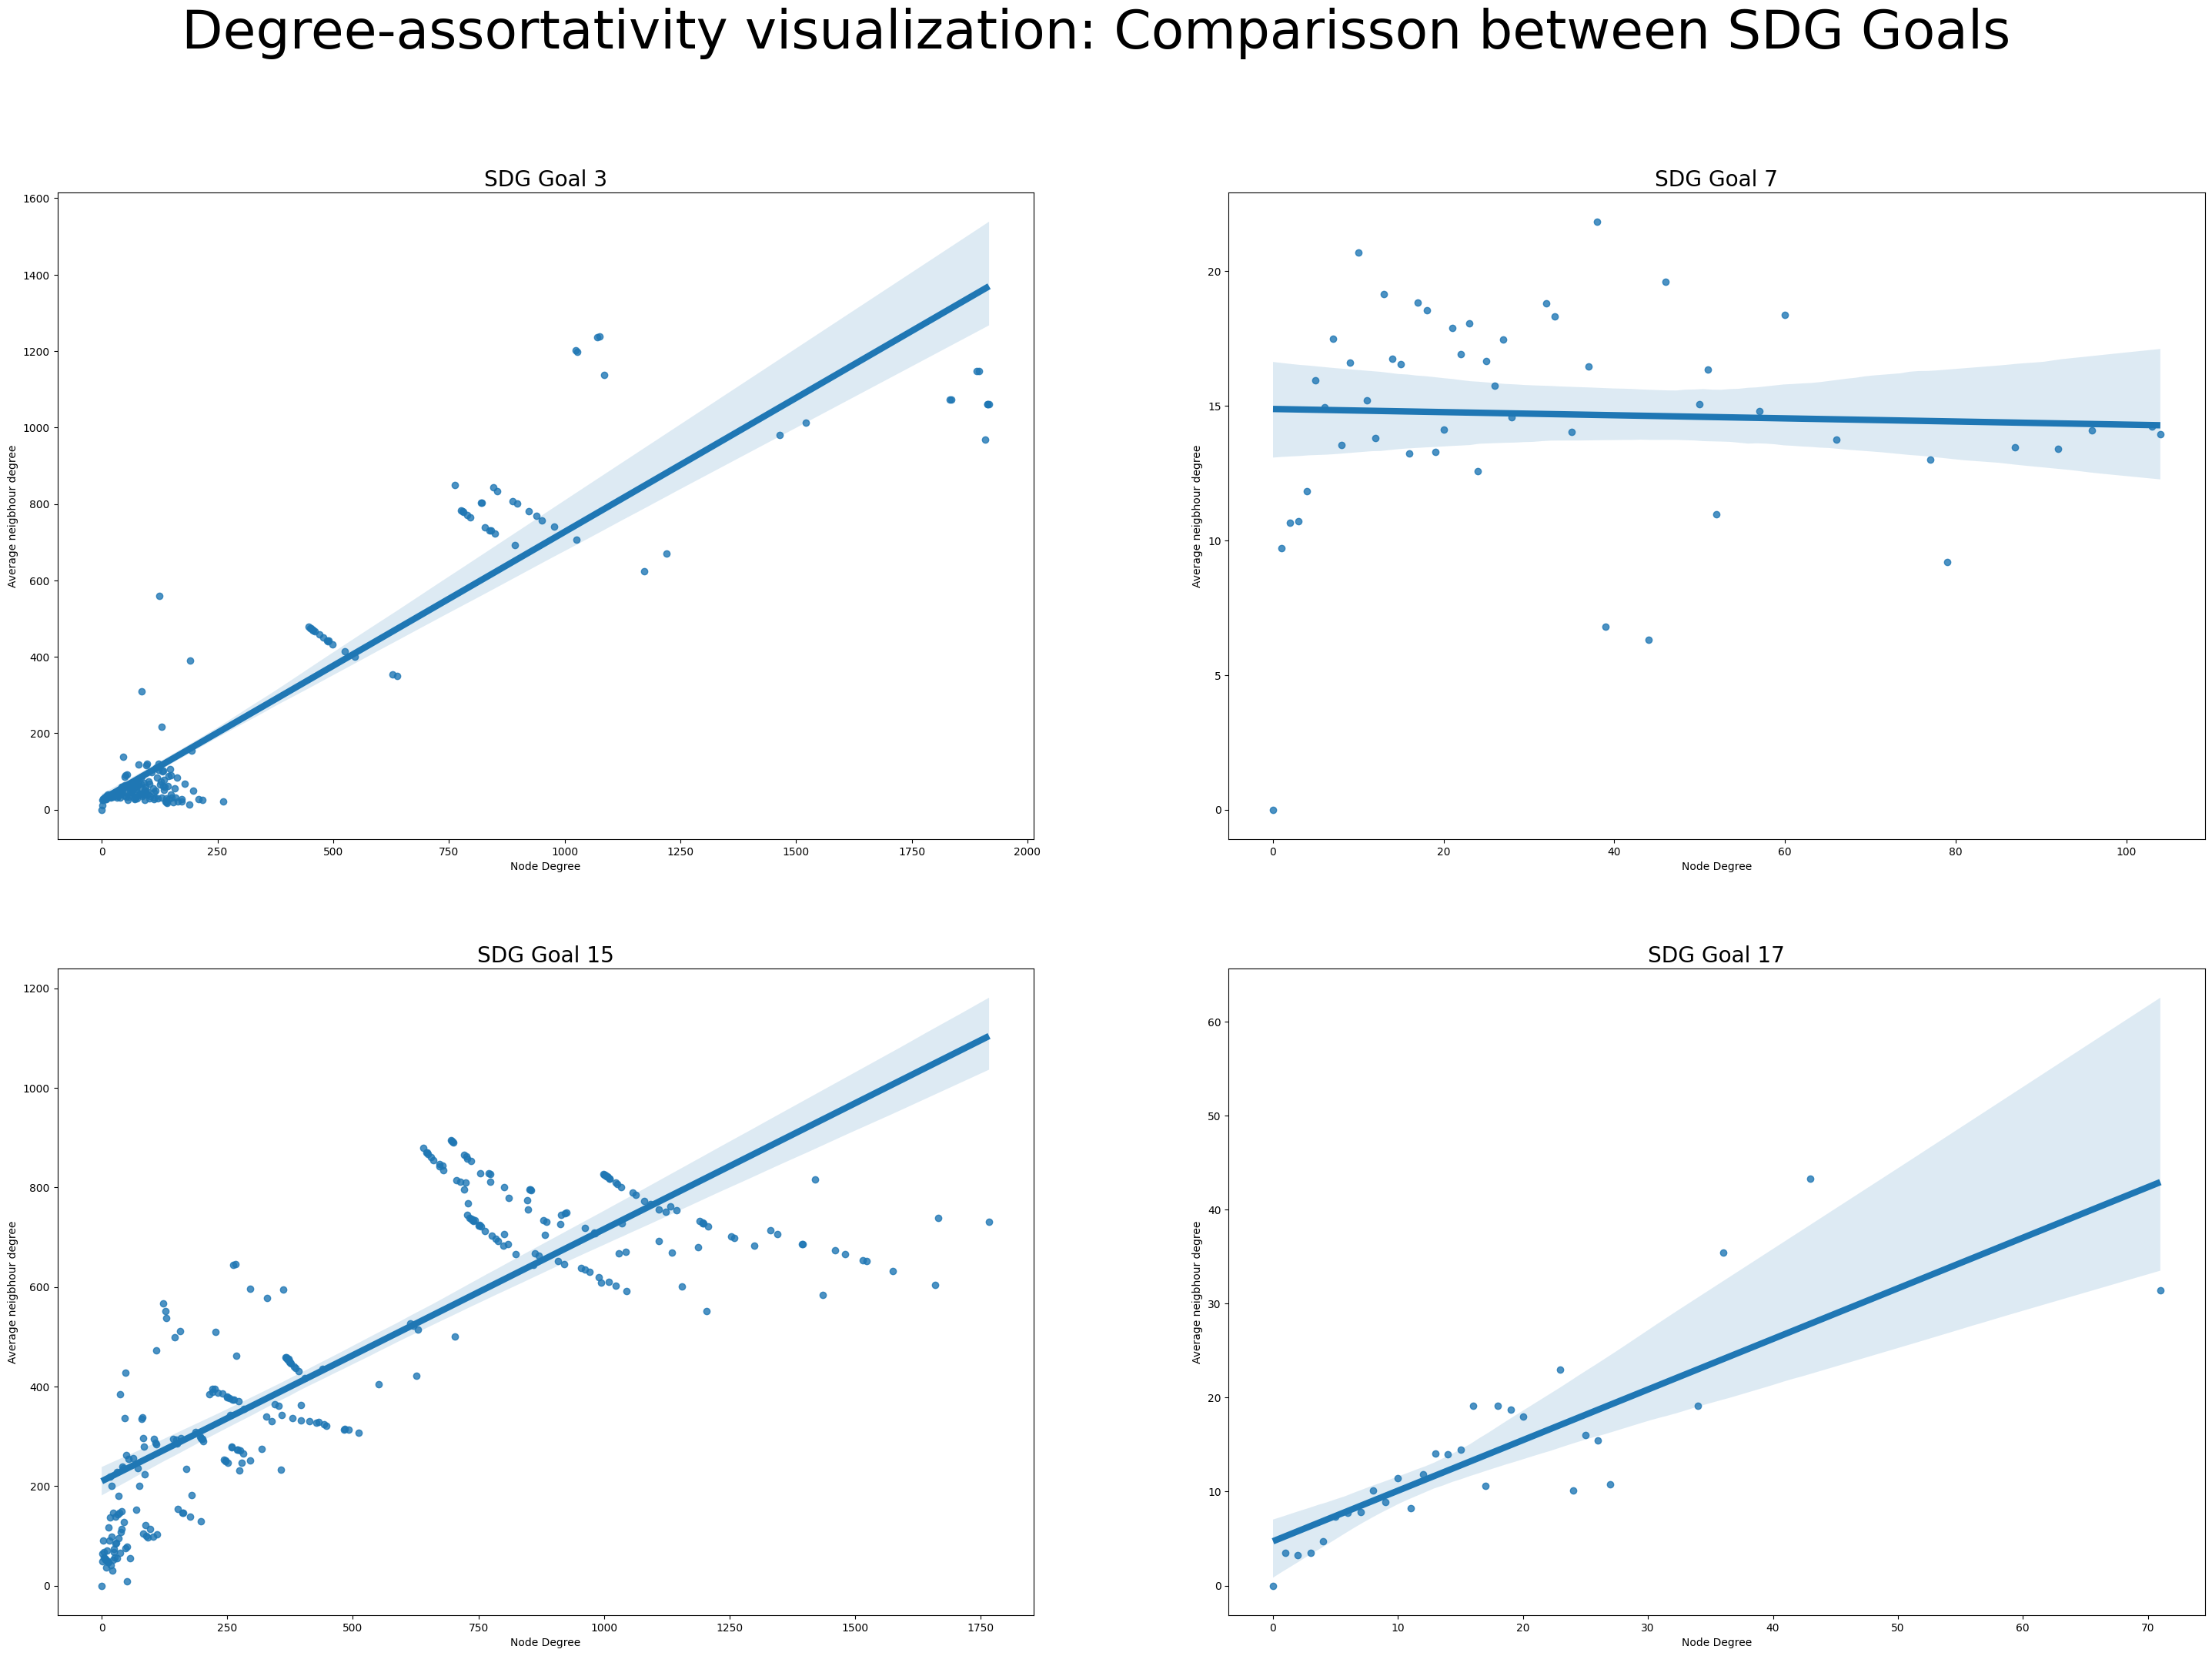

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(2,2,figsize=(12*3,8*3))
ODS_i = [3,7,15,17]

header = "\"| Rede | No. Vertex | No. Edges | Degree assortativity | No. Connected components | Giant component size | Avg. clustering coef. |\""
separator = "\"| --- | --- | --- | --- | --- | --- | --- |\""
linha_fmt = lambda d : f"\"| {ODS_i[d[1]]} | {d[0].number_of_nodes()} | {d[0].number_of_edges()} | {nx.degree_assortativity_coefficient(d[0])} | {nx.number_connected_components(d[0])} | {max(map(len, nx.connected_components(d[0])))} | {nx.average_clustering(d[0])} |\""
tablefp = "table.md"
!echo {header} > {tablefp}
!echo {separator} >> {tablefp}

for i in range(len(ODS_i)):
  g = coauth_from_csv(f"scopusODS{ODS_i[i]}.csv")
  degree, avg_neigh_degree = zip(*nx.average_degree_connectivity(g).items())

  !echo {linha_fmt([g, i])} >> {tablefp}
  # convert to list
  degree = list(degree)
  avg_neigh_degree = list(avg_neigh_degree)

  plt.style.use("fivethirtyeight")

  ax_i = (i//len(axs[0]), i%len(axs[0])) #nn posso fazer unpack disso nessa versão do python :(
  sns.regplot(x=degree,y=avg_neigh_degree,ax=axs[ax_i[0],ax_i[1]])

  axs[ax_i[0],ax_i[1]].set_xlabel("Node Degree")
  axs[ax_i[0],ax_i[1]].set_ylabel("Average neigbhour degree")
  axs[ax_i[0],ax_i[1]].set_title(f"SDG Goal {ODS_i[i]}")


# Save figure
fig.suptitle("Degree-assortativity visualization: Comparisson between SDG Goals", fontsize=50)
plt.savefig(f"degree_assortativity_ODS.png",
            format="png",
            dpi=400,
            bbox_inches="tight",
            transparent=True)

plt.show()

### Non-important misc code

Some lines out of curiosity to inspect what happened at goal 3 and a sanity check to be sure that edges ain't getting counted twice

In [ ]:
stop=True
if stop: raise Exception("Stopping the notebook execution earlier")
g = coauth_from_csv("scopusODS3.csv")
# Find the node with the highest degree
highest_degree_node = max(g.nodes(), key=lambda node: g.degree(node))

# Print the node with the highest degree
print(f"Node with the highest degree: {highest_degree_node}")

# Print the number of neighbors of the node with the highest degree
print(f"Number of neighbors: {g.degree(highest_degree_node)}")

print(f"Number of articles: {g.nodes()[highest_degree_node]['totArt']}")

print(f"Mean neighbors per article: {g.degree(highest_degree_node)/g.nodes()[highest_degree_node]['totArt']}")

Exception: Stopping the notebook execution earlier

In [ ]:
filtrar = lambda a: highest_degree_node in a

lista = [y for y in filter(filtrar, [x for x in g.edges()])]
listaAjustada = []
for tupla in lista:
  if tupla[1] == highest_degree_node:
    listaAjustada.append((tupla[1],tupla[0]))
    continue
  listaAjustada.append(tupla)

listaAjustada = sorted(listaAjustada)

In [ ]:
unicos = []
repetidos = 0
for tupla in listaAjustada:
  if not tupla in unicos:
    unicos.append(tupla)
    continue
  print(f"repeticao em {tupla}")
print(f"repetidos = {repetidos}")